In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt

In [ ]:
rlaif = load_dataset("berkeley-nest/Nectar")


In [3]:
rlaif_df = rlaif['train'].to_pandas()

In [4]:
rlaif_df

,prompt,answers,turns,num_responses,source,good_natured
0,\n\nHuman: 0.002 = 1000 \n1 = x?\n\nAssistant:,"[{'answer': 'To find the value of x, we can se...",1,7,[sharegpt],True
1,\n\nHuman: 0:00\nwhat's going on guys it's NAM...,[{'answer': 'Hello! It seems like you're shari...,1,7,[lmsys-chat-1m],True
2,\n\nHuman: 01011001 01001111 01010101 00100000...,[{'answer': 'The binary code you provided tran...,1,7,[anthropic-hh],True
3,"\n\nHuman: ""012345"", ""001122"", ""ee44aa"", ""abcd...","[{'answer': 'Sure, I can help you write a func...",1,7,[lmsys-chat-1m],True
4,\n\nHuman: #01 You are an assistant that helps...,"[{'answer': '{ ""thoughts"": ""Based on the c...",1,7,[lmsys-chat-1m],True
...,...,...,...,...,...,...
182949,"\n\nHuman: Zimkus, B. M., L. P. Lawson, M. F. ...","[{'answer': 'The Mascarene ridged frogs, also ...",1,7,[ultrachat],True
182950,\n\nHuman: Zoe goes to the store to buy soda a...,"[{'answer': 'First, we need to determine the t...",1,7,[flan_v2_cot],True
182951,\n\nHuman: Zomaria interruptolineana\n\nAssist...,[{'answer': 'Zomaria interruptolineana is a sp...,1,7,[lmsys-chat-1m],True
182952,\n\nHuman: Zombies don't need something when t...,[{'answer': 'Interesting riddle! The answer co...,2,7,[anthropic-hh],True


In [5]:
sources = rlaif_df.source.explode().value_counts()

<Axes: title={'center': 'Number of prompts from each source'}, xlabel='source', ylabel='count'>

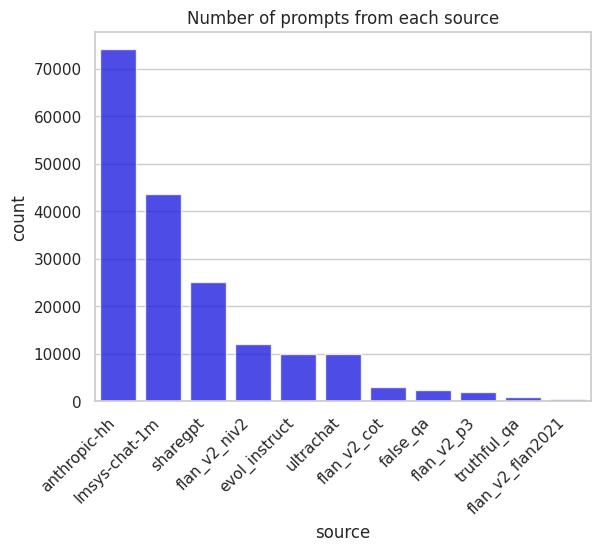

In [6]:
sns.set_theme(style="whitegrid")
g = sns.barplot(sources, color='blue', alpha=.8)
plt.xticks(rotation=45, horizontalalignment='right')
plt.title("Number of prompts from each source")
g

In [7]:
models = rlaif_df.answers.map(lambda ans: [a['model'] for a in ans]).explode().value_counts()

Text(0.5, 0, 'Model Name')

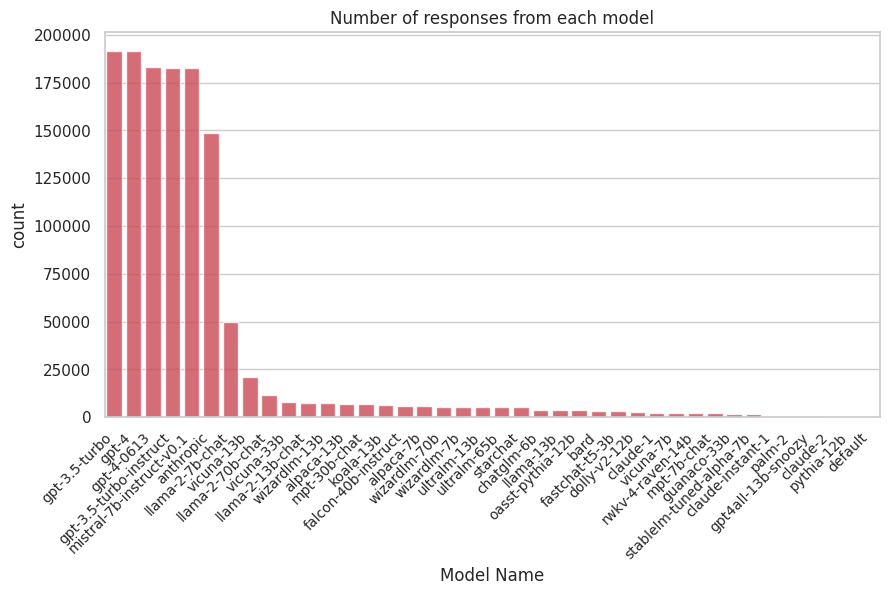

In [8]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_theme(style="whitegrid")
g = sns.barplot(models, color=sns.color_palette("rocket")[3], alpha=.8)
plt.xticks(rotation=45, horizontalalignment='right', fontsize=10)
plt.title("Number of responses from each model")
plt.xlabel("Model Name")

In [9]:
turns = rlaif_df.turns.value_counts()

Text(0.5, 1.0, 'Number of conversations of each turn (log scale)')

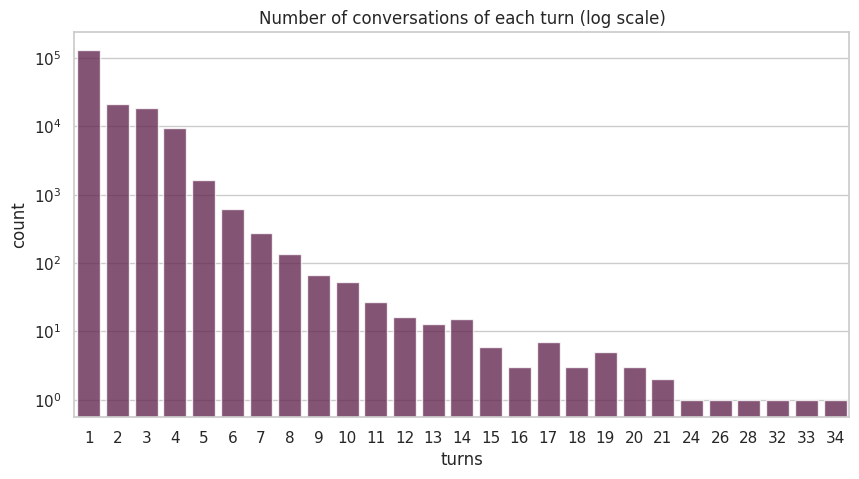

In [10]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_theme(style="whitegrid")
g = sns.barplot(turns, color=sns.color_palette("rocket")[1], alpha=.8)
g.set_yscale("log")
# plt.xticks(rotation=45, horizontalalignment='right', fontsize=10)
plt.title("Number of conversations of each turn (log scale)")

In [11]:
model_rank = pd.DataFrame.from_records(rlaif_df.answers.map(lambda ans: [{'model': a['model'], 'rank': a['rank']} for a in ans]).explode().values)

In [12]:
avg_rank = model_rank.groupby("model").agg('mean').sort_values('rank').reset_index()

Text(0, 0.5, 'Average Rank (lower is better)')

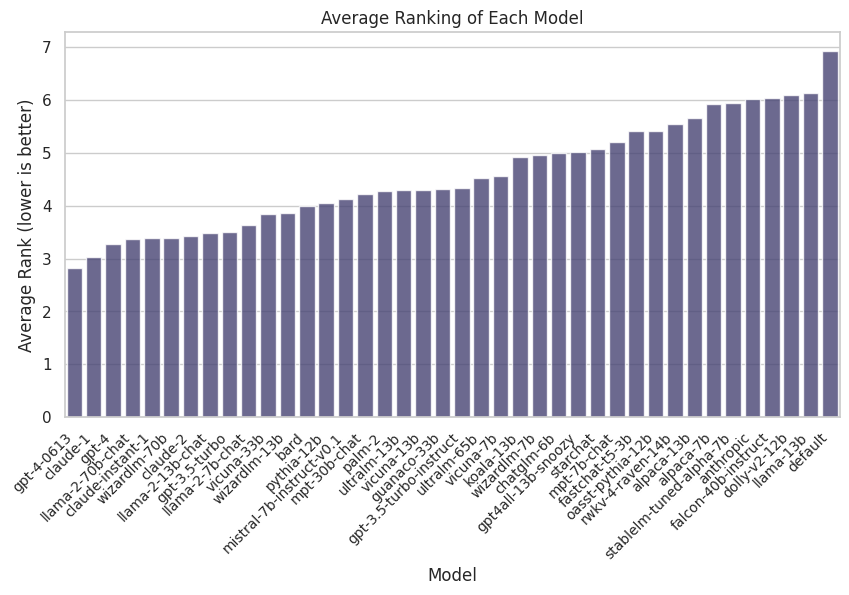

In [13]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_theme(style="whitegrid")
g = sns.barplot(avg_rank, x='model', y='rank', color=sns.color_palette("mako")[1], alpha=.8)
plt.xticks(rotation=45, horizontalalignment='right', fontsize=10)
plt.title("Average Ranking of Each Model")
plt.xlabel("Model")
plt.ylabel("Average Rank (lower is better)")

In [14]:
model_rank_dicts = rlaif_df.answers.map(lambda ans: dict((a['model'], a['rank']) for a in ans))
model_list = rlaif_df.answers.map(lambda ans: [a['model'] for a in ans]).explode().unique()

In [17]:
pairwises = []
index = []
for model1 in model_list:
    index.append(model1)
    row = {}
    for model2 in model_list:
        has_pair =  model_rank_dicts[model_rank_dicts.map(lambda d: model1 in d and model2 in d)]
        row[model2] = has_pair.map(lambda d: d[model1] < d[model2]).mean()
    pairwises.append(row)

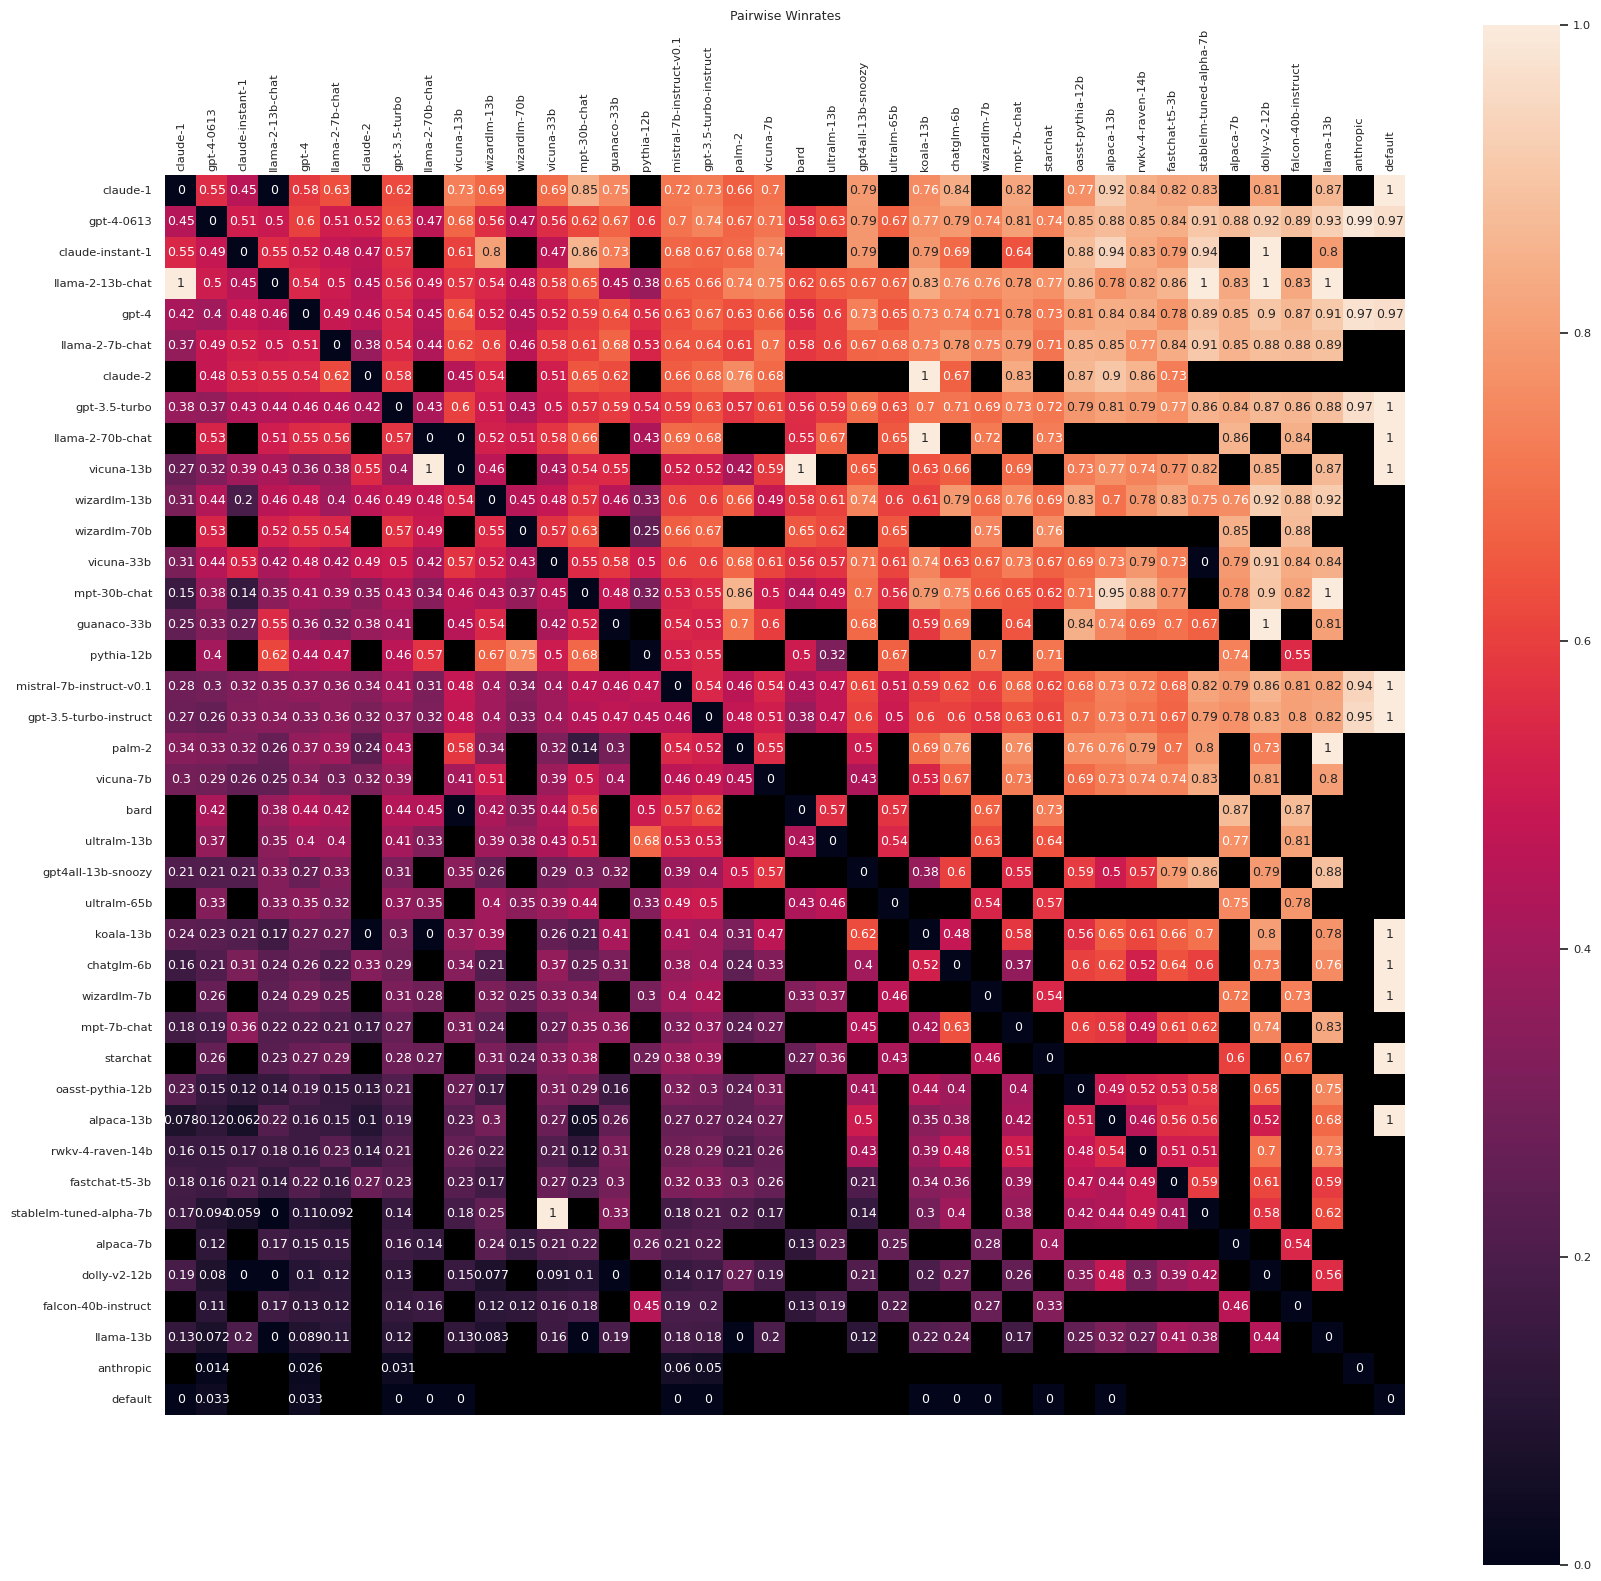

In [18]:
pairwise_df = pd.DataFrame(pairwises, index=index)
pairwise_df
pairwise_df['mean'] = pairwise_df.mean(axis=1)
pairwise_df.sort_values("mean", ascending=False, inplace=True)
pairwise_df.drop('mean', axis=1, inplace=True)
pairwise_df = pairwise_df[pairwise_df.mean(axis=1).sort_values(ascending=False).index]
sns.set_theme(style="dark")
sns.set_theme(rc={'figure.figsize':(20,20)})
sns.set_theme(font_scale=.75)
g = sns.heatmap(pairwise_df, annot=True,label='small', square=True)
g.grid(False)
g.set_facecolor('black')
plt.title("Pairwise Winrates")
g.xaxis.tick_top()
g.tick_params(axis=u'x', which=u'major',length=0, rotation=90)

In [19]:
pairwises_sum = []
index = []
for model1 in model_list:
    index.append(model1)
    row = {}
    for model2 in model_list:
        row[model2] = model_rank_dicts.map(lambda d: model1 in d and model2 in d).sum() if model1 != model2 else np.NaN
        row[model2] = row[model2] if row[model2] > 0 else np.NaN
    pairwises_sum.append(row)

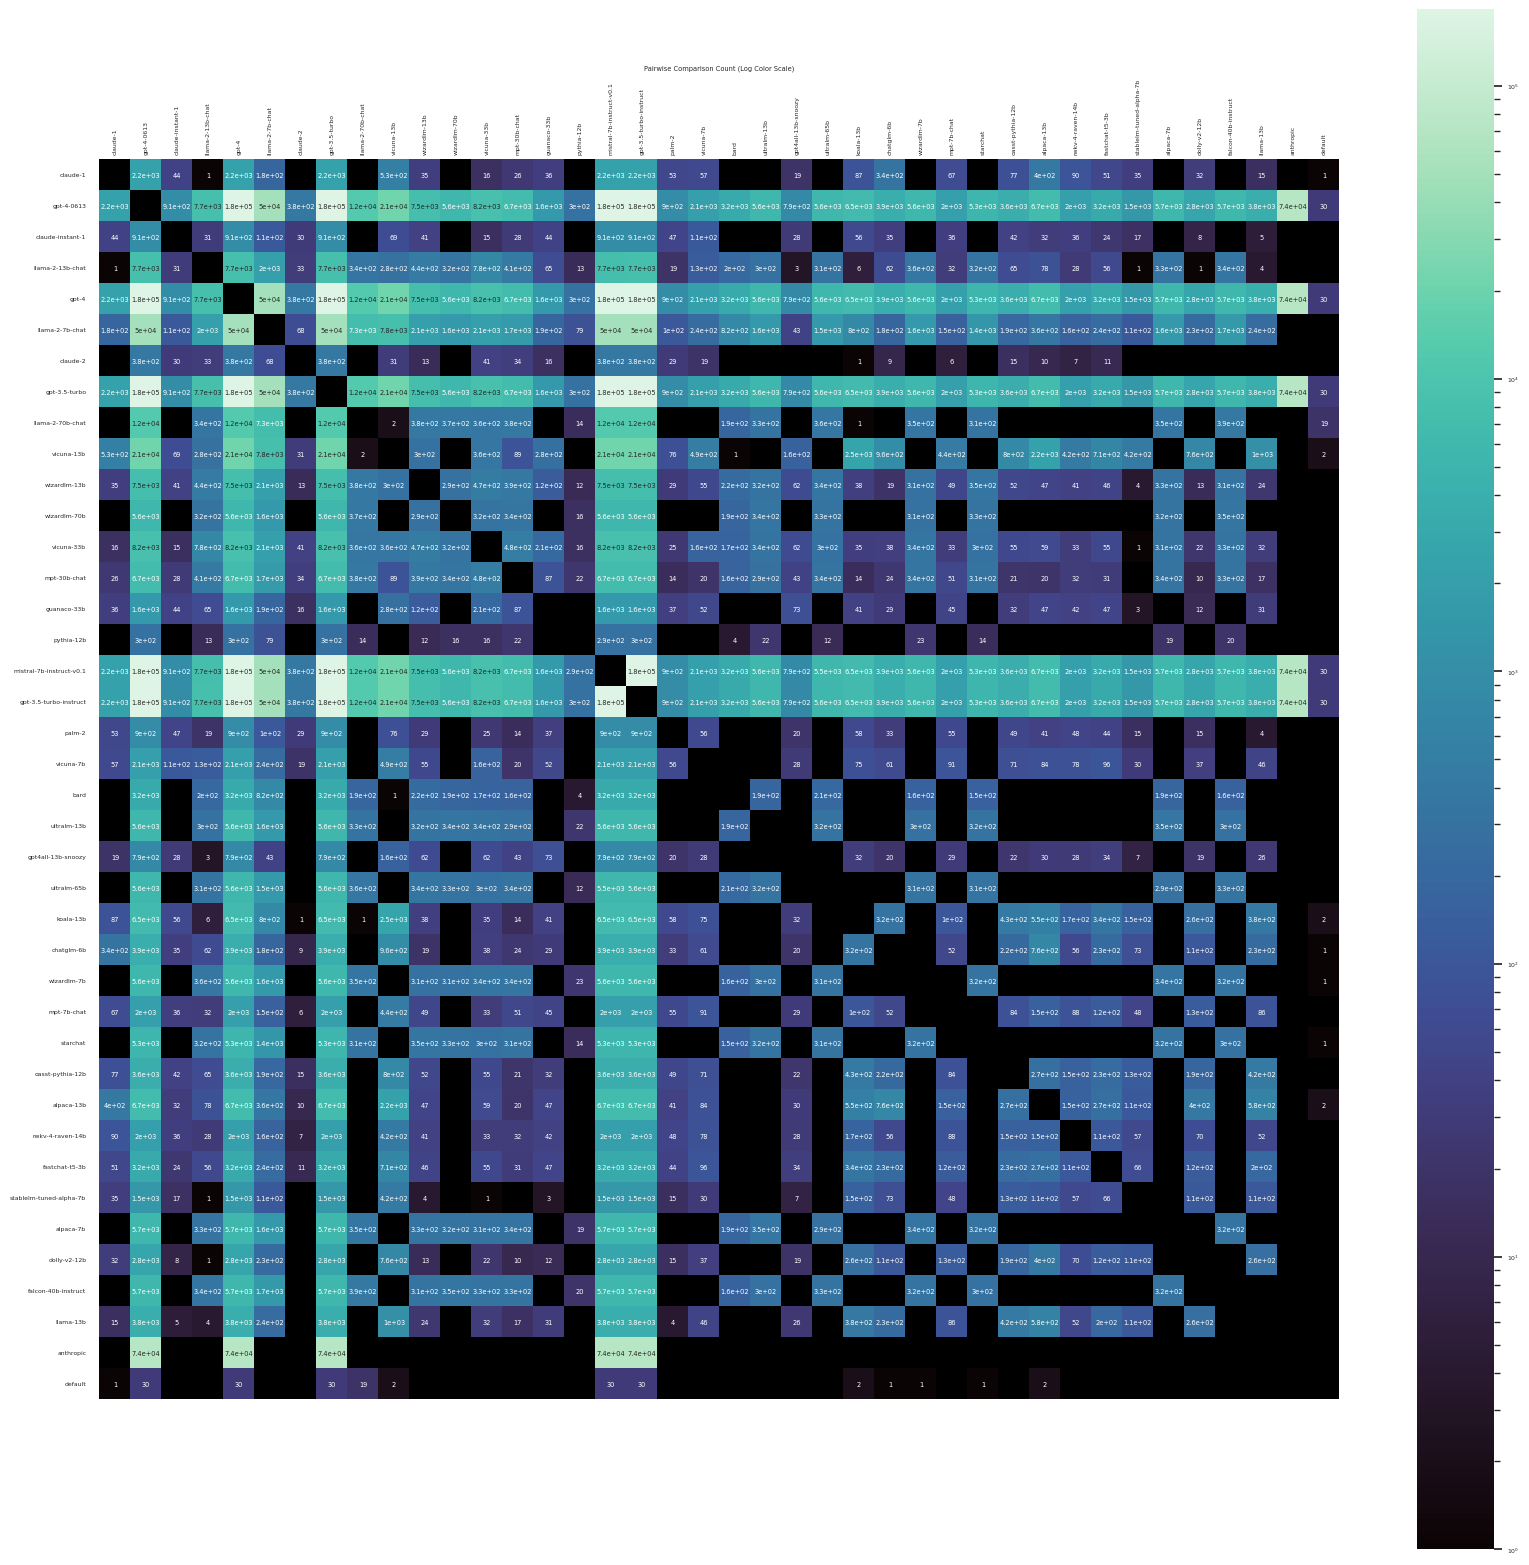

In [20]:
from matplotlib.colors import LogNorm, Normalize
pairwise_sum_df = pd.DataFrame(pairwises_sum, index=index)
sns.set_theme(rc={'figure.figsize':(20,20)})
sns.set_theme(font_scale=.4)
g = sns.heatmap(pairwise_sum_df.loc[pairwise_df.index, pairwise_df.index], annot=True, label='small', cmap='mako', norm=LogNorm(), square=True)
plt.title("Pairwise Comparison Count (Log Color Scale)")
g.grid(False)
g.set_facecolor('black')
g.xaxis.tick_top()
g.tick_params(axis=u'x', which=u'major',length=0, rotation=90)

In [21]:
pairwises_diff = []
index = []
for model1 in model_list:
    index.append(model1)
    row = {}
    for model2 in model_list:
        has_pair =  model_rank_dicts[model_rank_dicts.map(lambda d: model1 in d and model2 in d)]
        row[model2] = has_pair.map(lambda d: d[model2] - d[model1]).mean()
    pairwises_diff.append(row)

Text(0.5, 1.0, 'Pairwise Average Rank Placement Difference (Higher is better)')

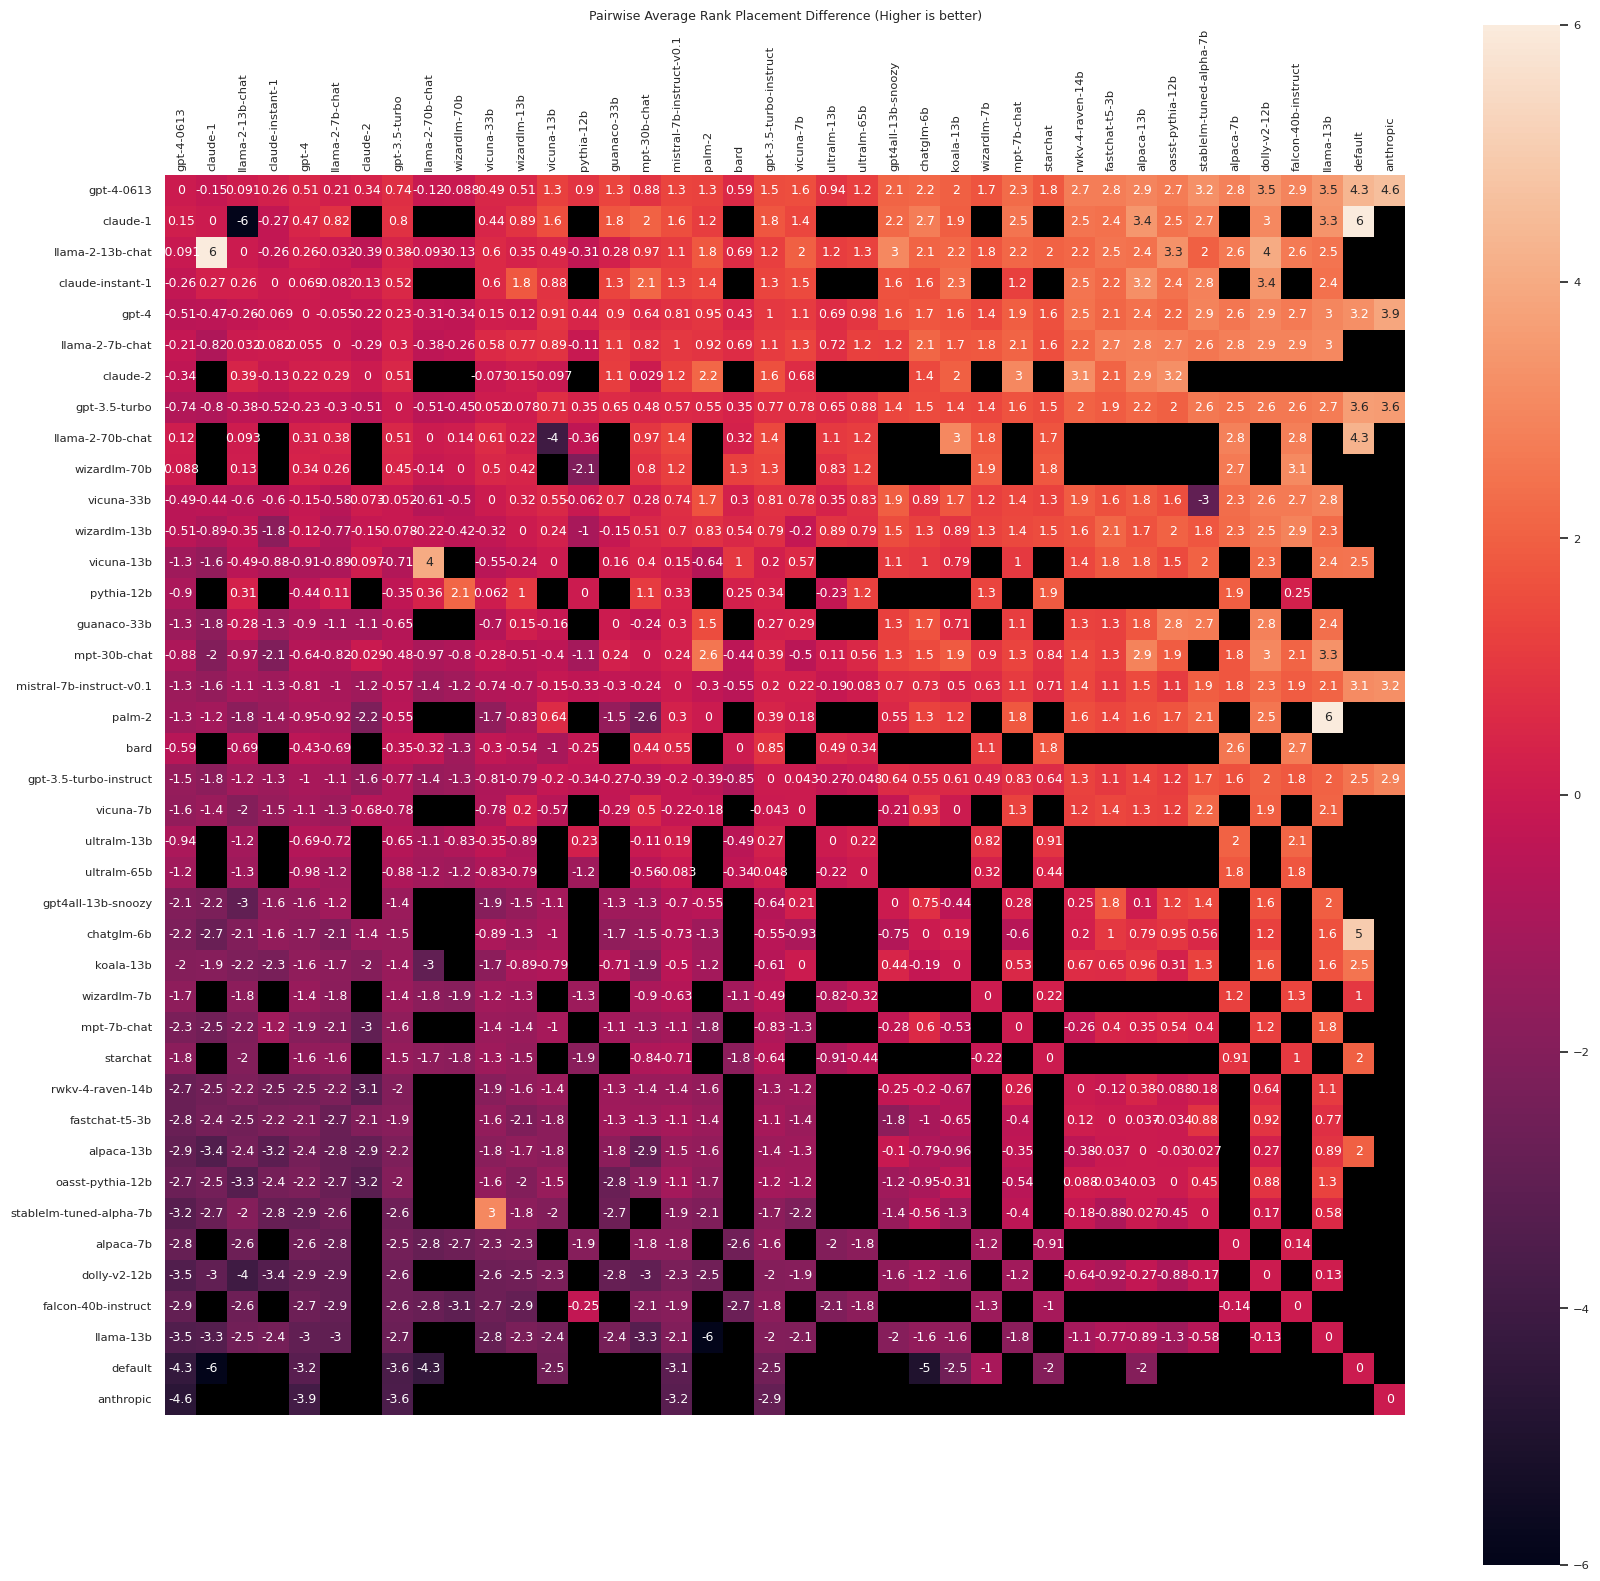

In [22]:
pairwise_diff_df = pd.DataFrame(pairwises_diff, index=index)
pairwise_diff_df
pairwise_diff_df['mean'] = pairwise_diff_df.mean(axis=1)
pairwise_diff_df.sort_values("mean", ascending=False, inplace=True)
pairwise_diff_df.drop('mean', axis=1, inplace=True)
pairwise_diff_df = pairwise_diff_df[pairwise_diff_df.mean(axis=1).sort_values(ascending=False).index]
sns.set_theme(style="dark")
sns.set(rc={'figure.figsize':(20,20)})
sns.set(font_scale=.75)
g = sns.heatmap(pairwise_diff_df, annot=True,label='small', square=True)
g.grid(False)
g.set_facecolor('black')
g.xaxis.tick_top()
g.tick_params(axis=u'x', which=u'major',length=0, rotation=90)
#plt.xticks(rotation=90, tick2On=False)

plt.title("Pairwise Average Rank Placement Difference (Higher is better)")